# `Setup`

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


### `Config`

In [2]:
MODEL_NAME = 'EfficientNetV1'

# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [3]:
# IMG Transformations Old
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImageTensor(),
    v2.ToDtype(torch.float32, scale=True)])


transforms_NEW = v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)
    ])


# val_transforms = T.Compose([
#     T.ToPILImage(),
#     T.Resize((224, 224), antialias=True),
#     v2.ToImageTensor(),
#     v2.ToDtype(torch.float32, scale=True)])


# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [4]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=transforms_NEW, 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

val_data = StateFarmDataset(config, 
                            split='test', 
                            transform=transforms_NEW, 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

Lenght of train data: 18070
Lenght of val data: 4354


In [5]:
train_data.img_labels = train_data.img_labels
train_data.metadata.target.value_counts(True)

safe driving                    0.108135
texting - left                  0.104815
talking on the phone - right    0.103985
talking on the phone - left     0.103486
drinking                        0.102656
operating the radio             0.102380
texting - right                 0.101051
talking to passenger            0.097399
reaching behind                 0.088268
hair and makeup                 0.087825
Name: target, dtype: float64

In [6]:
val_data.img_labels = val_data.img_labels
val_data.img_labels.classname.value_counts(True)

c0    0.122876
c6    0.107947
c5    0.106109
c4    0.104731
c3    0.103813
c1    0.101286
c2    0.100597
c7    0.093477
c9    0.084750
c8    0.074414
Name: classname, dtype: float64

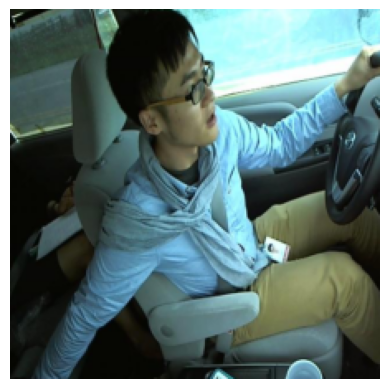

In [7]:
img, _ = train_data[1352]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

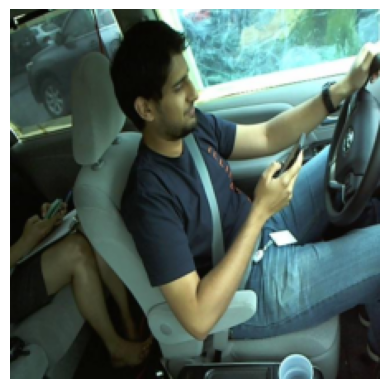

In [8]:
img, _ = val_data[100]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

#### `Model`

In [14]:
''' A simple Convolution, Batch Normalization, and Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#------------------------------------------------------------------------------

''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y
                                    
#------------------------------------------------------------------------------

''' Stochastic Depth Module'''

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

''' Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
    with Squeeze and Excitation Block and Stochastic Depth. 
'''

class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x
    

#----------------------------------------------------------------------------------------------

'''Efficient-net Class'''

class EfficientNet(nn.Module):
    
    '''Generic Efficient net class which takes width multiplier, Depth multiplier, and Survival Prob.'''
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [15]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}


In [16]:
def test():
    version = 'b0'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    net = EfficientNet(width_mult, depth_mult, dropout_rate)
    x = torch.rand(1, 3, res, res)
    y = net(x)
    print(y.size())
    
test()

torch.Size([1, 1000])


In [19]:
# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)


In [20]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [22]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [32, 10]                  --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─ConvBnAct: 2-1                              [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                              [32, 32, 112, 112]        --
│    └─MBConvN: 2-2                                [32, 16, 112, 112]        --
│    │    └─Identity: 3-4                          [32, 32, 112, 112]        --
│    │    └─ConvBnAct: 3-5                         [32, 32, 112, 112]        352
│    │    └─SqueezeExcitation: 3-6                 [32, 32, 112, 112]        552
│    │    └─ConvBnAct: 3-7                         [32, 16, 112, 112]        544
│    └─MBConvN: 2-3            

#### `Training Methods`

In [23]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [24]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [25]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [26]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Loop through epochs
    for epoch in range(epochs):
        print(f'Epoch {epoch+1} started...')
        
        # Set model to train mode and do pass over data
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)

        # lr Scheduler step
        scheduler.step(val_loss)
        

        # Print info
        print(f"Epoch {epoch+1} of {epochs} - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
            
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Model name
            timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
            name = f'{MODEL_NAME}_{timestamp}_epoch_{epoch+1}.pt'
            
            # Save model
            try:
                torch.save(model.state_dict(), config['outputs']['path'] + '/TinyVGG/' + name)
            except:
                os.mkdir(config['outputs']['path'] + '/TinyVGG/')
                torch.save(model.state_dict(), config['outputs']['path'] + '/TinyVGG/' + name)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
    
    return history

Epoch 1 started...
Epoch 1 of 50 - Train loss: 2.31191 - Train acc: 0.10746 - Val loss: 2.29486 - Val acc: 0.12614
Saving model with new best val_loss: 2.29486
Epoch 2 started...
Epoch 2 of 50 - Train loss: 2.30502 - Train acc: 0.11084 - Val loss: 2.29434 - Val acc: 0.14188
Saving model with new best val_loss: 2.29434
Epoch 3 started...
Epoch 3 of 50 - Train loss: 2.19187 - Train acc: 0.16733 - Val loss: 1.97376 - Val acc: 0.26209
Saving model with new best val_loss: 1.97376
Epoch 4 started...
Epoch 4 of 50 - Train loss: 1.75162 - Train acc: 0.33012 - Val loss: 1.77950 - Val acc: 0.34056
Saving model with new best val_loss: 1.77950
Epoch 5 started...
Epoch 5 of 50 - Train loss: 1.25407 - Train acc: 0.53940 - Val loss: 1.45787 - Val acc: 0.52509


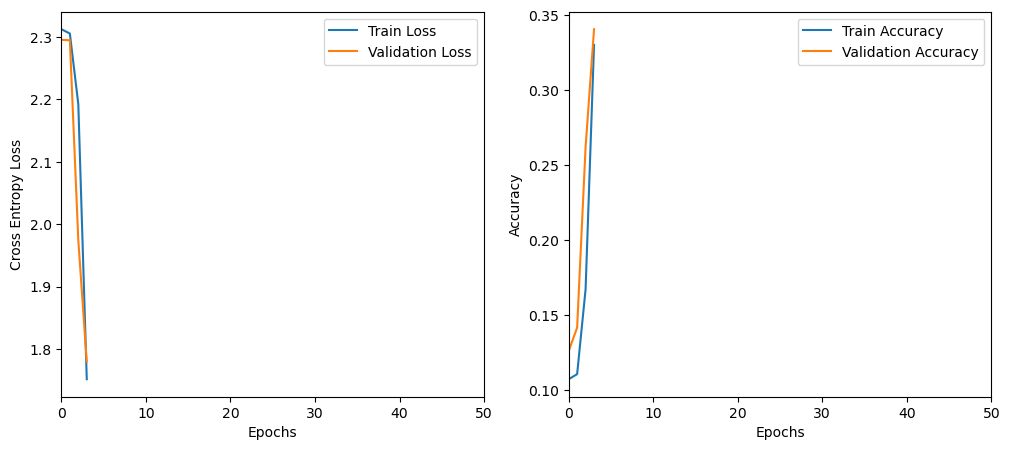

Saving model with new best val_loss: 1.45787
Epoch 6 started...
Epoch 6 of 50 - Train loss: 0.82131 - Train acc: 0.71829 - Val loss: 1.26876 - Val acc: 0.61861
Saving model with new best val_loss: 1.26876
Epoch 7 started...
Epoch 7 of 50 - Train loss: 0.51028 - Train acc: 0.83449 - Val loss: 1.04108 - Val acc: 0.68294
Saving model with new best val_loss: 1.04108
Epoch 8 started...
Epoch 8 of 50 - Train loss: 0.34758 - Train acc: 0.89101 - Val loss: 1.09050 - Val acc: 0.71008
Epoch 9 started...
Epoch 9 of 50 - Train loss: 0.25053 - Train acc: 0.92473 - Val loss: 1.26273 - Val acc: 0.67974
Epoch 10 started...
Epoch 10 of 50 - Train loss: 0.21187 - Train acc: 0.93590 - Val loss: 0.98587 - Val acc: 0.74909


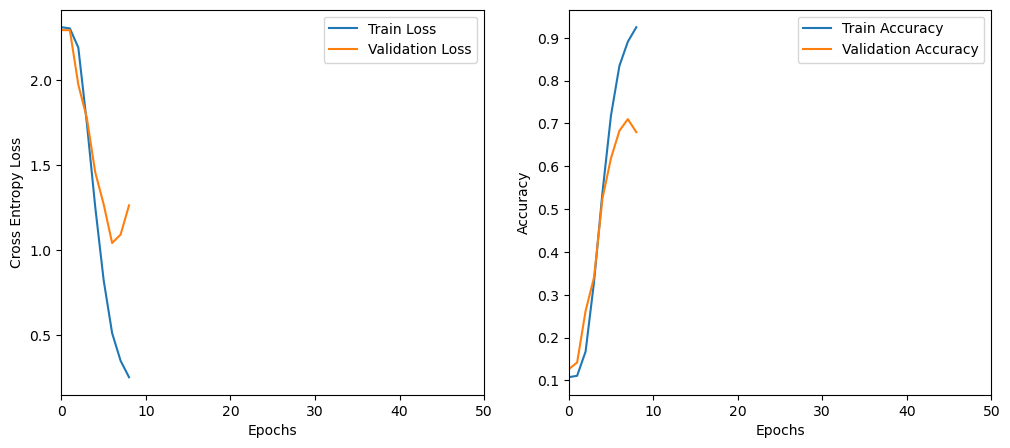

Saving model with new best val_loss: 0.98587
Epoch 11 started...
Epoch 11 of 50 - Train loss: 0.16651 - Train acc: 0.94892 - Val loss: 1.07641 - Val acc: 0.75502
Epoch 12 started...
Epoch 12 of 50 - Train loss: 0.14155 - Train acc: 0.95589 - Val loss: 1.06854 - Val acc: 0.74795
Epoch 13 started...
Epoch 13 of 50 - Train loss: 0.11628 - Train acc: 0.96565 - Val loss: 1.15551 - Val acc: 0.74498
Epoch 14 started...
Epoch 14 of 50 - Train loss: 0.10804 - Train acc: 0.96624 - Val loss: 1.04267 - Val acc: 0.77395
Epoch 15 started...
Epoch 15 of 50 - Train loss: 0.09282 - Train acc: 0.97190 - Val loss: 1.06982 - Val acc: 0.77943


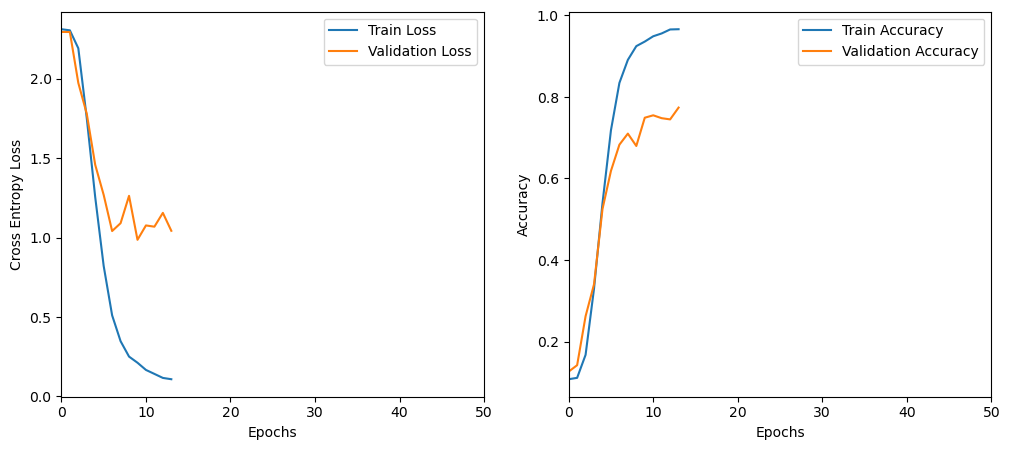

Epoch 16 started...
Epoch 00016: reducing learning rate of group 0 to 1.0000e-04.
Epoch 16 of 50 - Train loss: 0.09320 - Train acc: 0.97180 - Val loss: 0.98640 - Val acc: 0.78558
Epoch 17 started...
Epoch 17 of 50 - Train loss: 0.05919 - Train acc: 0.98269 - Val loss: 1.01549 - Val acc: 0.78057
Epoch 18 started...
Epoch 18 of 50 - Train loss: 0.05245 - Train acc: 0.98556 - Val loss: 0.97949 - Val acc: 0.78353
Saving model with new best val_loss: 0.97949
Epoch 19 started...
Epoch 19 of 50 - Train loss: 0.05017 - Train acc: 0.98639 - Val loss: 0.97580 - Val acc: 0.78034
Saving model with new best val_loss: 0.97580
Epoch 20 started...
Epoch 20 of 50 - Train loss: 0.04667 - Train acc: 0.98645 - Val loss: 0.94411 - Val acc: 0.78969


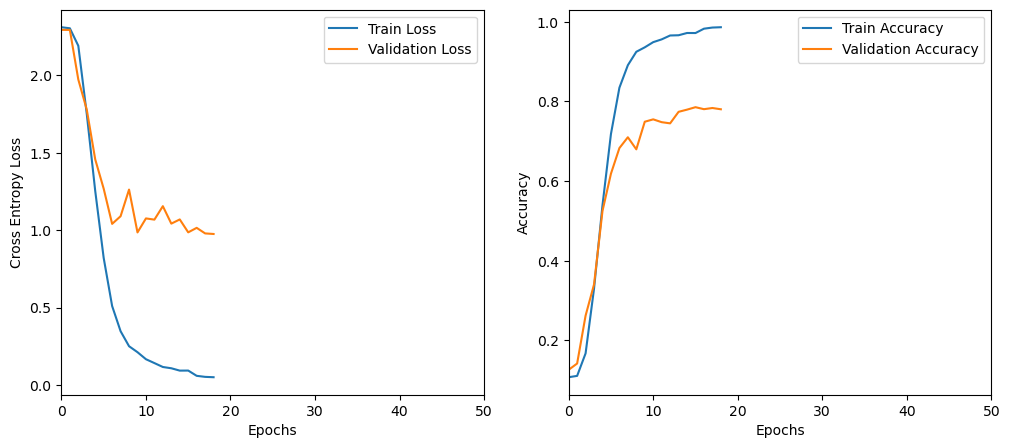

Saving model with new best val_loss: 0.94411
Epoch 21 started...
Epoch 21 of 50 - Train loss: 0.04611 - Train acc: 0.98756 - Val loss: 0.98051 - Val acc: 0.78011
Epoch 22 started...
Epoch 22 of 50 - Train loss: 0.04318 - Train acc: 0.98858 - Val loss: 1.01377 - Val acc: 0.78399
Epoch 23 started...
Epoch 23 of 50 - Train loss: 0.04133 - Train acc: 0.98814 - Val loss: 0.99138 - Val acc: 0.78650
Epoch 24 started...
Epoch 24 of 50 - Train loss: 0.04137 - Train acc: 0.98838 - Val loss: 1.02411 - Val acc: 0.78376
Epoch 25 started...
Epoch 25 of 50 - Train loss: 0.04181 - Train acc: 0.98889 - Val loss: 0.95338 - Val acc: 0.79151


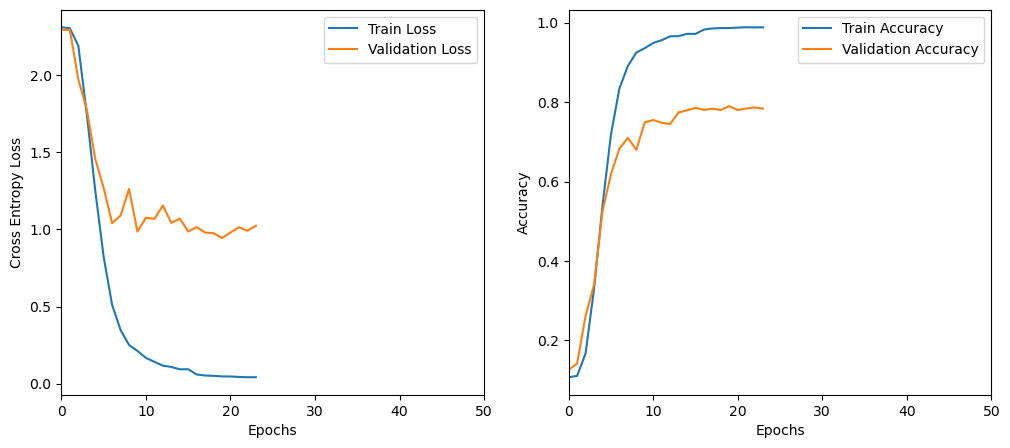

Epoch 26 started...
Epoch 00026: reducing learning rate of group 0 to 1.0000e-05.
Epoch 26 of 50 - Train loss: 0.04036 - Train acc: 0.98924 - Val loss: 0.98332 - Val acc: 0.78558
Epoch 27 started...
Epoch 27 of 50 - Train loss: 0.03940 - Train acc: 0.98938 - Val loss: 0.98544 - Val acc: 0.79151
Epoch 28 started...
Epoch 28 of 50 - Train loss: 0.03955 - Train acc: 0.98902 - Val loss: 0.97481 - Val acc: 0.79015
Epoch 29 started...
Epoch 29 of 50 - Train loss: 0.03801 - Train acc: 0.99015 - Val loss: 0.95799 - Val acc: 0.79745
Epoch 30 started...
Epoch 30 of 50 - Train loss: 0.03894 - Train acc: 0.98966 - Val loss: 0.96351 - Val acc: 0.78878


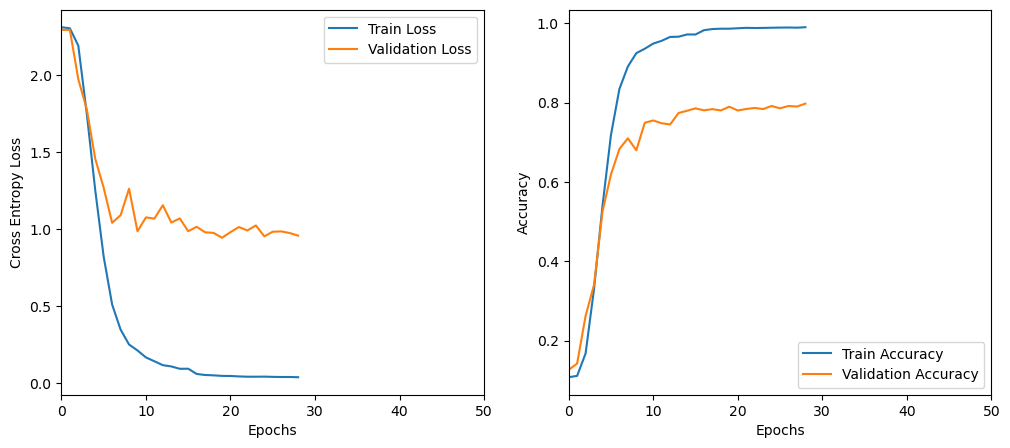

Epoch 31 started...
Epoch 31 of 50 - Train loss: 0.03910 - Train acc: 0.98999 - Val loss: 1.01674 - Val acc: 0.78581
Epoch 32 started...
Epoch 00032: reducing learning rate of group 0 to 1.0000e-06.
Epoch 32 of 50 - Train loss: 0.04010 - Train acc: 0.98905 - Val loss: 0.96688 - Val acc: 0.78786
Epoch 33 started...
Epoch 33 of 50 - Train loss: 0.03839 - Train acc: 0.98991 - Val loss: 0.95994 - Val acc: 0.79836
Epoch 34 started...
Epoch 34 of 50 - Train loss: 0.03973 - Train acc: 0.98905 - Val loss: 0.95350 - Val acc: 0.79425
Epoch 35 started...
Epoch 35 of 50 - Train loss: 0.03661 - Train acc: 0.99013 - Val loss: 1.02181 - Val acc: 0.78102


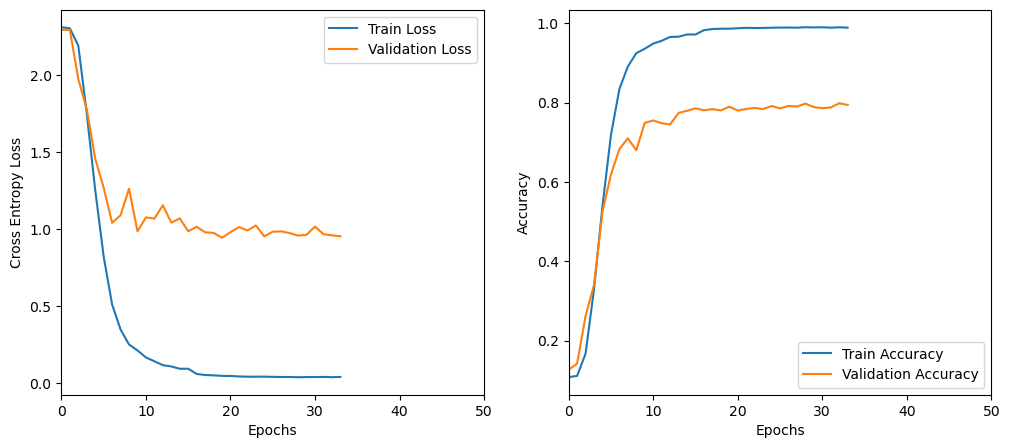

Epoch 36 started...
Epoch 36 of 50 - Train loss: 0.04188 - Train acc: 0.98877 - Val loss: 0.98880 - Val acc: 0.78901
Epoch 37 started...
Epoch 37 of 50 - Train loss: 0.03585 - Train acc: 0.99015 - Val loss: 1.01052 - Val acc: 0.78285
Epoch 38 started...
Epoch 00038: reducing learning rate of group 0 to 1.0000e-07.
Epoch 38 of 50 - Train loss: 0.03692 - Train acc: 0.99060 - Val loss: 0.98103 - Val acc: 0.79585
Epoch 39 started...
Epoch 39 of 50 - Train loss: 0.03759 - Train acc: 0.99065 - Val loss: 1.05245 - Val acc: 0.78171
Epoch 40 started...
Epoch 40 of 50 - Train loss: 0.03583 - Train acc: 0.99032 - Val loss: 0.98408 - Val acc: 0.79630


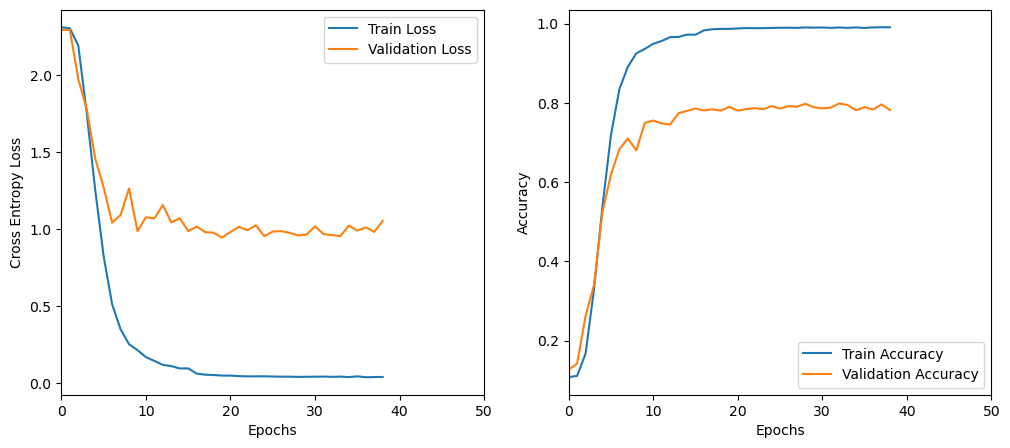

Epoch 41 started...
Epoch 41 of 50 - Train loss: 0.04030 - Train acc: 0.98888 - Val loss: 0.96127 - Val acc: 0.79402
Epoch 42 started...
Epoch 42 of 50 - Train loss: 0.03877 - Train acc: 0.99004 - Val loss: 0.99885 - Val acc: 0.79288
Epoch 43 started...
Epoch 43 of 50 - Train loss: 0.03740 - Train acc: 0.98991 - Val loss: 1.00217 - Val acc: 0.79037
Epoch 44 started...
Epoch 44 of 50 - Train loss: 0.03638 - Train acc: 0.99101 - Val loss: 1.01239 - Val acc: 0.79015
Epoch 45 started...
Epoch 45 of 50 - Train loss: 0.03768 - Train acc: 0.98955 - Val loss: 1.02919 - Val acc: 0.78627


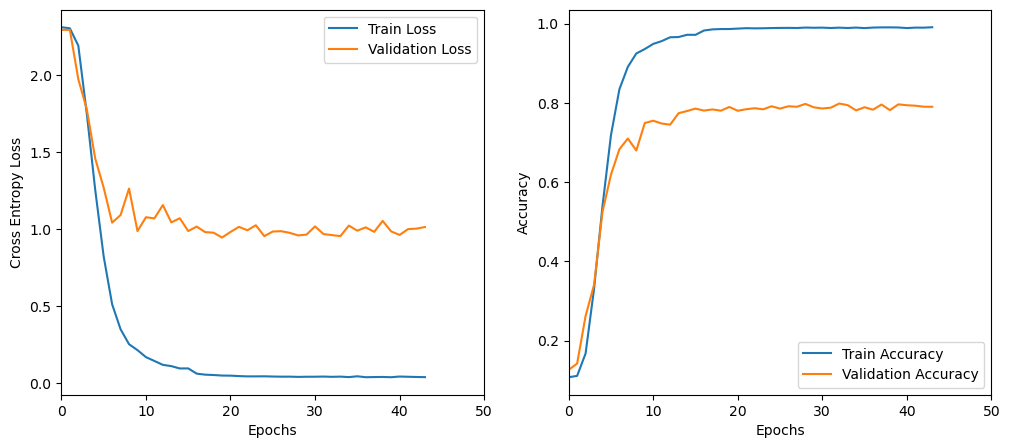

Epoch 46 started...
Epoch 46 of 50 - Train loss: 0.04047 - Train acc: 0.98899 - Val loss: 0.96010 - Val acc: 0.79083
Epoch 47 started...
Epoch 47 of 50 - Train loss: 0.03830 - Train acc: 0.99021 - Val loss: 0.92385 - Val acc: 0.79653
Saving model with new best val_loss: 0.92385
Epoch 48 started...
Epoch 48 of 50 - Train loss: 0.03916 - Train acc: 0.98927 - Val loss: 0.99697 - Val acc: 0.79266
Epoch 49 started...
Epoch 49 of 50 - Train loss: 0.03877 - Train acc: 0.98974 - Val loss: 0.97680 - Val acc: 0.79380
Epoch 50 started...
Epoch 50 of 50 - Train loss: 0.03823 - Train acc: 0.98830 - Val loss: 0.94359 - Val acc: 0.79334


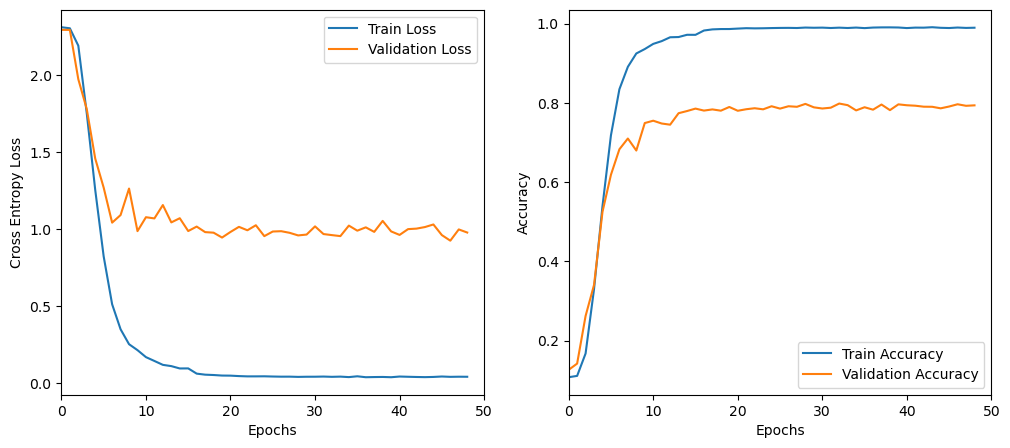

In [27]:
# Set random seeds
torch.manual_seed(42)

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)
model = model.to(device) # Load model to device.

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=5,
                                                       min_lr=1e-7,
                                                       verbose=True)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler)

TypeError: 'NoneType' object is not subscriptable

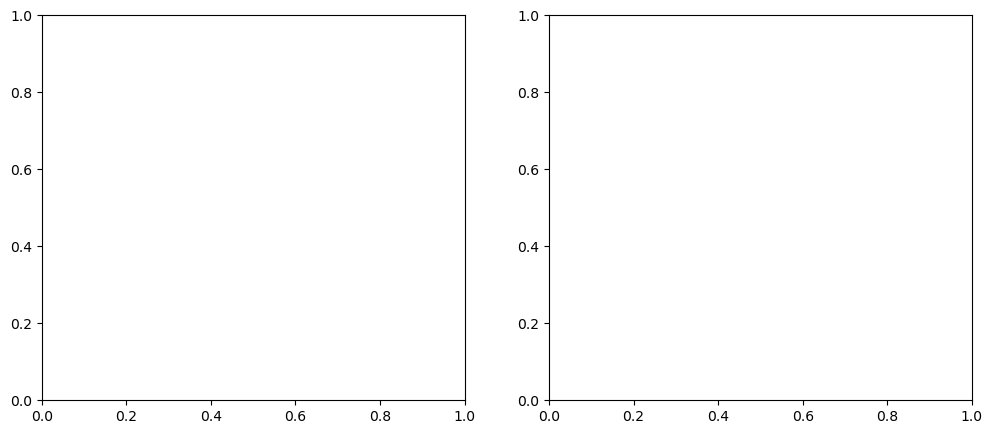

In [32]:
visualize_training(results)

### Testing on Test Images

In [52]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [53]:
# Loading image
test_image = read_image(os.path.join(config['dataset']['images']['test'], test_img))

In [54]:
test_image = train_data.transform(test_image)

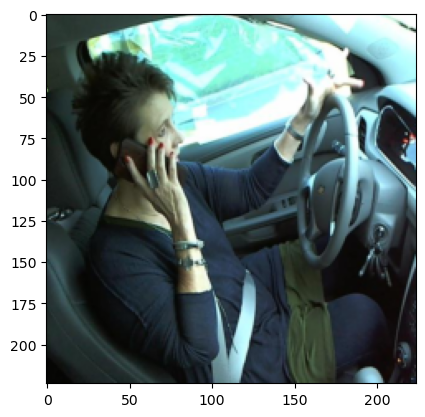

In [55]:
plt.imshow(test_image.permute(1, 2, 0))

In [56]:
test_pred = model(test_image.unsqueeze(0).to(device))

In [57]:
config['dataset']['class_mapping']['c' + str(test_pred.argmax(1).item())]

'talking on the phone - right'